## Code Supplement of _Reinforcement Learning with General LTL Objectives Is Impossible_

In this notebook, you will be able to: 
* [Reproduce the results in Section 5 and Appendix F of the paper](#paper-repro)
* [Visualize constructed counterexample MDPs for different LTL formulas](#mdp-construction)



In [95]:
from typing import Dict, Any, Callable, List, Optional, Union, Tuple

import math
import re
import subprocess
import tempfile
import pathlib
import dataclasses
import textwrap
import concurrent.futures
import os
import functools
import itertools
import collections
import hashlib
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

from scipy import interpolate

from tqdm.notebook import tqdm_notebook as tqdm
import inspect

from IPython.display import display, Markdown

import spot
from spot.jupyter import display_inline
spot.setup(show_default='.bans')

from num2tex import num2tex

import buddy
import graphviz

plt.style.use('seaborn-paper')

# Reproduction of Empirical Results (Section 5 and Appendix F) <a class="anchor" id="paper-repro"></a>

We first declare the main routine for estimating LTL-PAC probability under a particular setting.

The routine simply calls into (a modified version of) Mungojerrie to run multiple reinforcement-learning algorithm sessions in parallel obtain a Monte Carlo estimate of the LTL-PAC probability.

For documentation on Mungojerrie, please see https://plv.colorado.edu/wwwmungojerrie/docs/index.html.

In [96]:
def canonicalize_args(f):
    """Wrapper for functools.lru_cache() to canonicalize default                                                          
    and keyword arguments so cache hits are maximized."""

    @functools.wraps(f)
    def wrapper(*args, **kwargs):
        sig = inspect.getfullargspec(f.__wrapped__)

        # build newargs by filling in defaults, args, kwargs                                                            
        newargs = [None] * len(sig.args)
        newargs[-len(sig.defaults):] = sig.defaults
        newargs[:len(args)] = args
        for name, value in kwargs.items():
            newargs[sig.args.index(name)] = value

        return f(*newargs)

    return wrapper

class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)


def persistent_memo(func):
    cache_file = pathlib.Path(f"{func.__name__}.cache.json")
    try:
        with cache_file.open("r") as f:
            memo = json.load(f)
    except FileNotFoundError:
        memo = {}
    @functools.wraps(func)
    def wrapped(*args, **kwargs):
        key = json.dumps((args, kwargs), sort_keys=True, cls=NumpyEncoder)
        key_digest = hashlib.md5(key.encode("utf-8")).hexdigest()
        if key_digest not in memo:
            result = func(*args, **kwargs)
            memo[key_digest] = {"args": args, "kwargs": kwargs, "result": result}
            with cache_file.open("w+") as f:
                json.dump(memo, f, sort_keys=True, cls=NumpyEncoder)
        return memo[key_digest]["result"]
    return wrapped


mungojerrie_path = "mungojerrie/build/mungojerrie"

pattern = re.compile(rf"PAC Probability for tol (\d+(\.\d*)?) is: (?P<satprob>\d+(\.\d*)?)±(?P<std>\d+(\.\d*)?)")

@canonicalize_args
@persistent_memo
def estimate_pac_probability(epsilon: float, 
                             model: str, 
                             min_num_samples: int = 100, 
                             max_est_std: float = 1e-3,
                             reward_type: str = "multi-discount", 
                             discount: float = 0.99999,
                             gammaB: float = 0.99, 
                             learn="Q",
                             lr_schedule: Union[Tuple[str, float], Tuple[str, float, float]] = ("kkt", 10),
                             explore_schedule: Tuple[float, float] = (0.1, 0.1),
                             ep_number: int = 100, 
                             ep_length: int = 10,
                             tolerance=0.,
                             sarsa_lambda: Optional[float] = None,
                             model_params: Dict[str, Any] = None):
    """Estimate LTL-PAC probability for a specific setting, calls into Mungojerrie.
    
    Args:
        epsilon: the $\epsilon$ in LTL-PAC definition.
        model: the environment MDP to solve for. 
               there should be two files with paths `models/{env}.prism` and `models/{env}.ltl`, specifying the
               environment MDP in PRISM format and the LTL formula.
        min_num_samples: minimum repeats to run for Monte Carlo estimation.
        max_est_std: the standard deviation below which the Monte Carlo estimation should terminate.
        reward_type: the reward scheme to use for Mungojerrie.
        discount, gammaB, learn, ep_number, ep_length, tolerance, sarsa_lambda: see documentation of mungojerrie.
        lr_schedule, explore_schedule: a wrapper interface for mungojerrie's learning_rate and exploration schedules. 
        model_params: the parameters to be formatted into the PRISM model (e.g., the parameter $p$ in Figure 2 of the paper).
    
    Returns:
        the estimated LTL-PAC probability and its estimated standard deviation.
    """
    if model_params is None:
        model_params = {}
    
    with tempfile.NamedTemporaryFile(mode='w+') as tmp:
        model_str = pathlib.Path(f"{model}.prism").read_text()
        model_str = model_str.format(**model_params)
        tmp.write(model_str)
        tmp.flush()
        try:
            cmd = [
                    mungojerrie_path, tmp.name, 
                    "--epsilon", "1e-12", # necessary for accurate model checking 
                    "--ltl-file", f"{model}.ltl",
                    "--learn", learn, 
                    "--reward-type", reward_type, 
                    "--discount", str(discount),
                    "--gammaB", str(gammaB),
                    "--tolerance", str(tolerance), 
                    # Learning rates
                    "--alpha", str(lr_schedule[1]) if lr_schedule[0] == "linear" else "0.1",
                    "--linear-lr-decay", str(lr_schedule[2]) if lr_schedule[0] == "linear" else "-1",
                    "--kkt-lr-decay", str(lr_schedule[1]) if lr_schedule[0] == "kkt" else "-1",
                    # Exploration
                    "--explore", str(explore_schedule[0]),
                    "--linear-explore-decay", str(explore_schedule[1]),
                    "--ep-number", str(ep_number),
                    "--ep-length", str(ep_length),
                    # PAC settings
                    "--est-pac",
                    "--est-pac-probability-min-samples", str(min_num_samples),
                    "--est-pac-max-std", str(max_est_std),
                    "--est-pac-epsilon", str(epsilon),
                    "--lambda", str(sarsa_lambda) if sarsa_lambda else "0"
                    # "--seed", str(2),
            ]
#             print(cmd)
            output = subprocess.check_output(
                cmd,
                stderr=subprocess.STDOUT
            )
        except subprocess.CalledProcessError as exc:
            print("Status : FAIL", exc.returncode, exc.output)
            raise exc
    output = output.decode("utf-8")
    match = pattern.search(output)
    pac_prob = float(match.group("satprob"))
    pac_prob_std = float(match.group("std"))
    return pac_prob, pac_prob_std

Below we define a function that scans over a grid of settings (see Section 5 of the paper) to estimate all those setting's LTL-PAC probabilities.

We also define a function for visualization of the obtained results.

In [128]:
default_ps = np.geomspace(0.1, 1e-3, num=5)
default_ep_numbers = np.geomspace(1, 10000, num=21, dtype=int)[1:]
default_ep_length = 10

def collect_pac_probs(env: str, 
                      ps: List[float] = default_ps, 
                      ep_numbers: List[int] = default_ep_numbers,
                      ep_length: int = default_ep_length, 
                      rl_algo: str = "Q", 
                      reward_type: str = "multi-discount", 
                      skip_after_stable: int = float("inf")):
    """Estimate LTL-PAC probability for varying settings.
    
    Args:
        env: see :py:func:`estimate_pac_probability`.
        ps: the parameteter $p$ to the environment MDP.
        ep_numbers: an array of $N$, the number of epsidoes, to run an algorithm for.
        ep_length: each episode's length until an environment reset. 
            This is a hyper-parameter of reinforcement-learning algorithms in Mungojerrie.
            `ep_length * ep_number` is the total number of samples available to an algorithm.
        rl_algo: the learning algorithm to use for Mungojerrie. 
            Must be One of `Q` (Q-learning), `DQ`(Double Q-learning), `SL` (SARSA($\lambda$)).
        reward_type: the reward scheme to use for Mungojerrie.
        skip_after_stable: skip the rest of the estimation for larger $N$, when the estimated LTL-PAC probability 
            stablizes at 1. Skipping vastly reduces computation time, but assumes an algorithm cannot do worse with 
            larger number of samples. By default this is set to `inf` which means no skipping.
    
    Returns:
        a dict of estimated LTL-PAC probabilities, and a dict of their estimated standard deviations.
    """
    lr_schedule = {
        "Q": ("kkt", 10),
        "DQ": ("kkt", 30),
        "SL": ("kkt", 10),
    }[rl_algo]

    explore_schedule = {
        "Q": (1.0, 0.1),
        "DQ": (1.0, 0.1),
        "SL": (1.0, 0.001),
    }[rl_algo]

    probs, errs = collections.defaultdict(list), collections.defaultdict(list)
    for p in tqdm(ps, desc=f"<{reward_type} | {rl_algo} > Iteration over p"):
        err_zero_cnt = 0
        for ep_number in tqdm(ep_numbers, leave=False, desc="Iteration over N"):
            if err_zero_cnt < skip_after_stable:
                prob, err = estimate_pac_probability(
                    epsilon=0.1, 
                    model=f"models/{env}",
                    model_params=dict(P=p),
                    reward_type=reward_type,
                    max_est_std=1e-2, 
                    discount=0.99999,
                    gammaB=0.99,
                    learn=rl_algo,
                    lr_schedule=lr_schedule,
                    explore_schedule=explore_schedule,
                    ep_number=ep_number, 
                    ep_length=ep_length,
                    sarsa_lambda=0.)
#                 print(p, ep_number, prob, err)
            if prob == 1.0 and err == 0:
                err_zero_cnt += 1
            else:
                err_zero_cnt = 0
            probs[p].append(prob)
            errs[p].append(err)
    
    return probs, errs


def interpolate_and_intersect_pac_delta(probs, 
                                        errs, 
                                        delta:float = 0.1, 
                                        ep_numbers: List[int] = default_ep_numbers, 
                                        ep_length: int = default_ep_length):
    """Interpolates the LTL-PAC curves (the left in Figure 3) to obtain the intercepts (the right in Figure 3).
    
    Args:
        probs, errs: the estimated LTL-PAC probabilities and their standard deviations, 
                     by :py:func:`collect_pac_probs`.
        delta: the desired LTL-PAC probability to reach. 
               For example, `delta=0.1` means we would like to intercept 
               at 0.9 LTL-PAC probability.
        ep_numbers, ep_length: see :py:func:`collect_pac_probs`.
    
    Returns:
        the intercept curves and their errors.
    """
    line, lower, upper = [], [], []
    for p in probs:
        prob = np.array(probs[p])
        err = np.array(errs[p])
        try:
            line.append(interpolate.UnivariateSpline(ep_numbers,  prob - (1 - delta), s=0).roots()[0])
            lower.append(interpolate.UnivariateSpline(ep_numbers, prob - err * 2 - (1 - delta), s=0).roots()[0])
            upper.append(interpolate.UnivariateSpline(ep_numbers, prob + err * 2 - (1 - delta), s=0).roots()[0])
        except IndexError:
            # The intercept does not exist, so we set them to +inf
            line.append(np.inf)
            lower.append(np.inf)
            upper.append(np.inf)
    return  (np.array(x) * ep_length for x in (lower, line, upper))

def frexp10(x):
    exp = int(math.floor(math.log10(abs(x))))
    a, b = x / 10**exp, exp
    if a == 0:
        return "$0$"
    if a == 1:
        return f"$10^{b}$"
    return f"${a:.1f} \\times 10^{b}$"

def plot_pac_probs(env: str, 
                   probs, 
                   errs, 
                   ep_numbers: List[int] = default_ep_numbers,
                   ep_length: int = default_ep_length, 
                   rl_algo: str = "Q", 
                   reward_type: str = "multi-discount", 
                   title: Optional[str]=None, 
                   delta=0.1, 
                   max_intercept_num_samples:Optional[int]=None, 
                   plot_for_paper: bool = True):
    """Plots the figure as in the paper's Figure 3."""
    if title is None:
        with pathlib.Path(f"models/{env}.prism").open("r") as f:
            lines = f.readlines()
            env_title = env
            for line in lines:
                m = re.match(r"\/\/\s*\@title\s*:\s*(?P<env_title>[^\n]*)\n", line)
                if m:
                    env_title = m.group("env_title")
                    break
    
    sample_numbers = ep_numbers * ep_length
    if plot_for_paper:
        plt.figure(figsize=(3.5,2.1))
    ps = sorted(probs.keys(), reverse=True)
    lines = []
    linestyles = ['solid', (0, (3, 1, 1, 1, 1, 1)), 'dashdot', 'dashed', 'dotted']
    linestyles_iter = itertools.cycle(linestyles)
    for p in ps:
        prob, err = map(np.array, (probs[p], errs[p]))
        err = np.maximum(err, 1e-3) * 2 # we visualize 2 * std in the plots
        filler = plt.fill_between(sample_numbers, prob-err, prob+err, alpha=0.4)
        eb = plt.errorbar(sample_numbers, prob, yerr=err, linewidth=1, linestyle=next(linestyles_iter))
        lines.append((filler, eb))

    plt.gca().set_xscale("log")
    major_ticks = np.geomspace(sample_numbers[0], sample_numbers[-1], num=5, dtype=int)
    minor_ticks = np.linspace(major_ticks[:-1], major_ticks[1:], num=6)[1:-1].T.ravel()
    plt.gca().set_xticks(major_ticks)
    plt.gca().set_xticklabels([frexp10(x) for x in major_ticks])
    plt.gca().set_xticks(minor_ticks, minor=True)
    plt.gca().set_xticklabels([], minor=True)
    plt.gca().tick_params(which="major", length=4)
    plt.gca().tick_params(which="minor", length=3)
    plt.gca().set_xlabel("#samples")
    plt.gca().set_ylabel("LTL-PAC Prob.")

    plt.axhline(1 - delta, color="#000", alpha=0.4, linestyle="--", linewidth=0.6)
    
    pstex = [f"{p:.0e}".replace("-0","-") for p in ps]
    plt.legend(lines, pstex, title="$p$", handlelength=1.2, loc="lower right")
    rl_algo_to_name = {"Q": "Q-Learning", "DQ": "Double Q-Learning", "SL": "Sarsa($0$)"}
    reward_type_to_name = {}
    if title is None:
        plt.title(f"{env_title} | {reward_type_to_name.get(reward_type, reward_type)} | {rl_algo_to_name[rl_algo]}")
    elif title != "":
        plt.title(title)
    plt.gcf().tight_layout()
    plt.gcf().savefig(f"plots/{reward_type}-{rl_algo}-{env}", dpi=600)
    plt.show()
    
    # Plot intercept
    lower, line, upper = interpolate_and_intersect_pac_delta(probs, errs, 
                                                             delta=delta, 
                                                             ep_numbers=ep_numbers, 
                                                             ep_length=ep_length)
    if plot_for_paper:
        plt.figure(figsize=(2.217,2.1))
    plt.errorbar(range(len(ps)), line, yerr=np.array([line-lower, upper-line]), color="#000", alpha=0.4)
    plt.gca().set_xlabel("$p$")
    plt.gca().set_xticks(range(len(ps)))
    plt.gca().set_xticklabels(pstex)
    plt.gca().set_ylabel("#samples")
    if max_intercept_num_samples is not None:
        plt.ylim([0, max_intercept_num_samples])
    plt.gcf().tight_layout()
    if title is None:
        plt.title(f"{env_title} | {reward_type_to_name.get(reward_type, reward_type)} | {rl_algo_to_name[rl_algo]}")
    elif title != "":
        plt.title(title)
    plt.gcf().savefig(f"plots/{reward_type}-{rl_algo}-{env}-intercept-{str(delta).replace('.','_')}", dpi=600)
    plt.show()


## Reproduction of Results in Appendix F

Running the cell below reproduces results in Appendix F. 

It takes approximately 2 hours to finish all the experiments. 
For quick reproduction, you may want to run for less `reward_types` and `rl_algos`.

Note that the code caches previously ran experiments, so it's ok to interrupt and re-execute any time.
If you are using Docker, the cache is recreated for every new container launch (meaning that by default, caches are cleared if you exit Docker).
If you are in your own environment, the cache is stored at `estimate_pac_probability.cache.json`. You may delete or rename this file to fully re-execute a reproduction.

Also note that due to multi-threading's non-determinism, the results might not look exactly the same as we report in the paper. However, the difference should be minimal since we always repeat enough simulations until the standard deviation of the estimate is within $0.01$. 

<zeta-reach | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

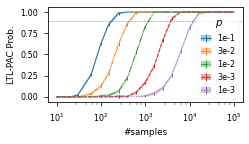

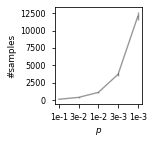

<zeta-acc | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

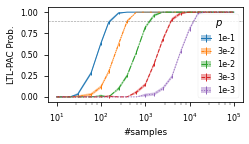

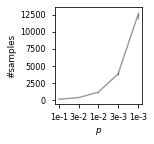

<zeta-discount | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

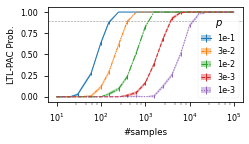

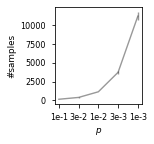

<multi-discount | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

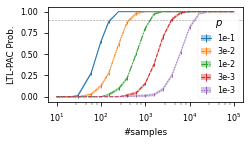

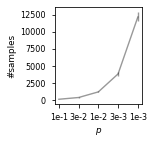

<reward-on-acc | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

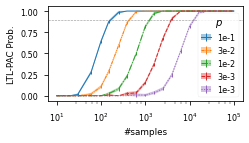

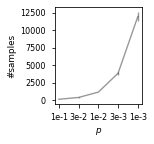

<zeta-reach | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

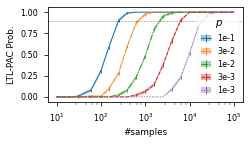

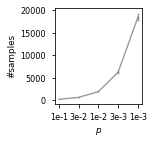

<zeta-acc | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

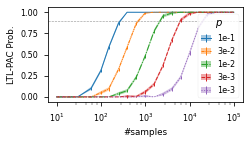

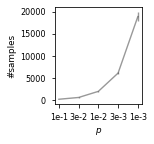

<zeta-discount | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

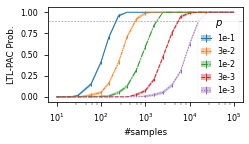

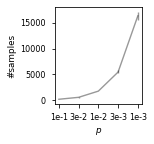

<multi-discount | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

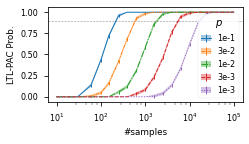

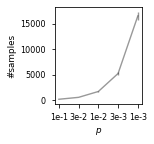

<reward-on-acc | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

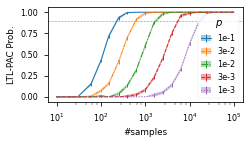

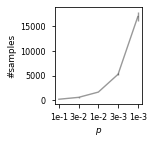

<zeta-reach | SL > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

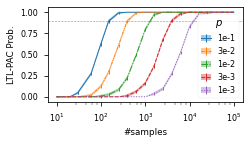

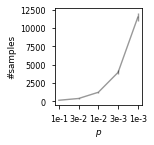

<zeta-acc | SL > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

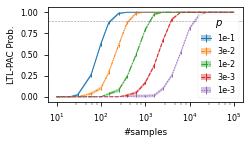

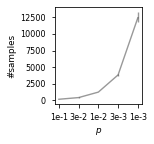

<zeta-discount | SL > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

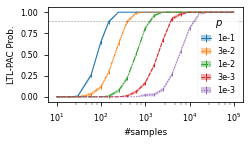

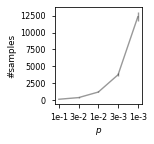

<multi-discount | SL > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

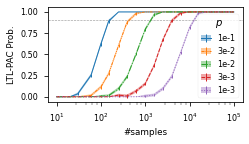

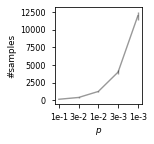

<reward-on-acc | SL > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

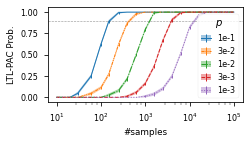

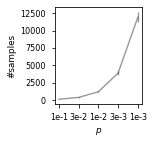

In [129]:
pathlib.Path("plots").mkdir(exist_ok=True)

env = "rl_ltl_pac_paper"
reward_types = ["zeta-reach", "zeta-acc", "zeta-discount", "multi-discount", "reward-on-acc"]
rl_algos = ["Q", "DQ", "SL"]
# Comment out below to run for only multi-discount and Q-learning
# reward_types = ["multi-discount"]
# rl_algos = ["Q"]
for rl_algo, reward_type in itertools.product(rl_algos, reward_types):
    probs, errs = collect_pac_probs(env, rl_algo=rl_algo, reward_type=reward_type, skip_after_stable=3)
    plot_pac_probs(env, probs, errs, rl_algo=rl_algo, reward_type=reward_type, title="")

# Counterexample MDP Construction <a class="anchor" id="mdp-construction"></a>

Below we implement an algorithm to construct two counterexample MDPs for any LTL formula not in `Finitary`.

The algorithm is derived from the proof of existence of counterexample MDPs in Section 4.4 and Appendix 
D.

Note that the construction of a counterexample MDPs for an LTL formula may not be unique, and our algorithm only returns one valid counterexample. In particular, it does not guarantee a minimal construction (e.g., the number of the states in the MDPs is minimal).

In particular, the algorithm below constructs a different counterexample for the formula $\mathsf{F} h$ than the one used in the empirical justification section (Section 5) of the paper. 
This is, again, because our algorith below does not return a minimal construction, while in our evaluation, we manually construct a minimal counterexample.

In [5]:
AP = Tuple[bool]

@dataclasses.dataclass
class TrapChain:
    prefix: AP
    cycle: AP
        
@dataclasses.dataclass
class RegularState:
    label: AP
    trap: TrapChain

@dataclasses.dataclass
class ConstructedMDP:
    aps: Tuple[str]
    g_prefix: List[AP]
    g_cycle: List[AP]
    h_prefix: List[AP]
    h_cycle: List[AP]
    q_prefix: List[AP]
    q_cycle: List[AP]
    is_accepting_example: bool

def _collect_formula_aps(formula: spot.formula):
    """Collects the set of atomic propositions in formula."""
    aps = set()
    formula.traverse(lambda f: aps.add(f) if f.kind() == spot.op_ap else None)
    return aps


def _bdd_to_tuple(aps, bdd_dict, bdd):
    """Converts a buddy.bdd to a Python tuple."""
    ret = []
    for ap in aps:
        v = buddy.bdd_ithvar(bdd_dict.varnum(ap))
        ret.append(bool(buddy.bdd_implies(bdd, v))) 
    return tuple(ret)


def _rejecting_run_starting_with(aps: Tuple[str], aut, state):
    """Computes a trap chain by a rejecting run in `aut` starting from `state`.
    
    Args:
        aps: the atomic propositions.
        aut: the automaton to compute the rejecting run on.
        state: the state in `aut` from which the run should start.
    
    Returns:
        a rejecting run.
    """
    current_init_state = aut.get_init_state()
    aut.set_init_state(aut.state_number(state))
    c_aut = spot.complement(aut)
    rej_run = c_aut.accepting_run().reduce()
    aut.set_init_state(aut.state_number(current_init_state))
    assert rej_run is not None, f"Must exists at least one rejecting run from state {state}"
    return rej_run


def to_dra(formula: Union[str, spot.formula]):
    """Converts a LTL formula into a Deterministic Rabin Automaton."""
    if isinstance(formula, str):
        formula = spot.formula(formula)
    aut = formula.translate("deterministic", "complete", "parity", "sbacc")
    aut = spot.to_generalized_rabin(aut, False)
    return aut


def _construct_mdp(formula: Union[str, spot.formula], is_accepting_example=True):
    """Constructs an counter-example MDP for a particular LTL formula. 
    
    One can show that the constructed MDP has no sample efficient RL algorithm.
    
    Args:
        formula: the LTL formula.
        is_accepting_example: whether try to create an accepting or rejecting 
          example.

    Returns:
        a ConstructedMDP, or None if the example does not exist.
    """
    if isinstance(formula, str):
        formula = spot.formula(formula)

    if not is_accepting_example:
      formula = spot.formula_Not(formula)

    # aut = to_dra(formula)
    aut = formula.translate("deterministic", "complete", "parity", "sbacc")
    terminal_aut = spot.decompose_scc(aut, "t")
    if terminal_aut is None:
        # Case pure G
        weakly_accepting_run = aut.accepting_run()
    else:
        weakly_accepting_run = aut.intersecting_run(spot.complement(terminal_aut))
    
    if weakly_accepting_run is None:
        return None
    
    weakly_accepting_run = weakly_accepting_run.reduce()
    aps = tuple(_collect_formula_aps(formula))
    
    rej_run = _rejecting_run_starting_with(aps, aut, weakly_accepting_run.cycle[-1].s)
    
    def to_ap(x):
        return _bdd_to_tuple(aps, aut.get_dict(), x.label)
    
    h_prefix = [] 
    h_cycle = [to_ap(x) for x in weakly_accepting_run.cycle]
    q_prefix = [to_ap(x) for x in rej_run.prefix]
    q_cycle = [to_ap(x) for x in rej_run.cycle]

    if not is_accepting_example:
        h_prefix, q_prefix = q_prefix, h_prefix
        h_cycle, q_cycle = q_cycle, h_cycle
    
    return ConstructedMDP(
        aps=tuple(a.to_str() for a in aps),
        g_prefix=[to_ap(x) for x in weakly_accepting_run.prefix], 
        g_cycle=[to_ap(x) for x in weakly_accepting_run.cycle],
        h_prefix=h_prefix, 
        h_cycle=h_cycle,
        q_prefix=q_prefix,
        q_cycle=q_cycle, 
        is_accepting_example=is_accepting_example)


def construct_mdp(formula: Union[str, spot.formula]):
  """Constructs an either accepting or rejecting example MDP.
  
  Args: 
    formula: the LTL formula.
  
  Returns:
    a ConstructedMDP, or None if no example exists (the formula is in B).
  """
  mdp = _construct_mdp(formula, True)
  if mdp is None:
    mdp = _construct_mdp(formula, False)
    if mdp is None:
      assert spot.mp_class(formula) == 'B'
  return mdp    

In [6]:
def to_graphviz(mdp: ConstructedMDP, m1_or_m2 = "M1"):
    assert m1_or_m2 in ("M1", "M2")
    
    g = graphviz.Digraph('MDP')
    g.attr(rankdir='LR')
    g.attr('node', shape='circle')

    def label_to_str(lab):
        return ",".join([f"{ap}={int(x)}" for ap, x in zip(mdp.aps, lab)])
    
    def add_single_edge(g, s1, s2, action="a1", prob="1"):
        if prob == "1":
            g.edge(s1, s2, label="", color="black")
        else:
            color = dict(a1="blue", a2="orange")[action]
            g.edge(s1, s2, label=f"{action}, {prob}", color=color, fontcolor=color)
        
    def add_parallel_edge(g, s1, s2, prob="1"):
        if prob in (1, "1"):
            add_single_edge(g, s1, s2, prob=prob)
        else:
            add_single_edge(g, s1, s2, action="a1", prob=prob)
            add_single_edge(g, s1, s2, action="a2", prob=prob)

    def add_path(prefix, cycle, name: str, init=True, color="green", wrap_cycle=True):
        states = list(itertools.chain(prefix, cycle))
        with g.subgraph(name=name) as bg:
#             bg.attr(rank="same")
            bg.attr('node', fillcolor=color, style='filled')
            if init:
                bg.node("init", style="invis")
                bg.edge("init", f"{name}-0")
            for s, state in enumerate(states):
                bg.node(f"{name}-{s}", label=label_to_str(state))
            for s1 in range(len(states) - 1):
                s2 = s1 + 1
                add_parallel_edge(bg, f"{name}-{s1}", f"{name}-{s2}", prob="1")
            if wrap_cycle:
                add_parallel_edge(bg, 
                                  f"{name}-{len(prefix) + len(cycle) - 1}", 
                                  f"{name}-{len(prefix)}", 
                                  prob="1")

    add_path(mdp.g_prefix + mdp.g_cycle, [], name="g_region", wrap_cycle=False, color="grey")
    add_path(mdp.h_prefix, mdp.h_cycle, 
             name="h_region", init=False, color="green")
    add_path(mdp.q_prefix, mdp.q_cycle, 
             name="q_region", init=False, color="red")
    
    last_state_in_g = len(mdp.g_prefix + mdp.g_cycle) - 1
    add_parallel_edge(g, 
                      f"g_region-{last_state_in_g}", 
                      f"g_region-{len(mdp.g_prefix)}", 
                      prob="1-p")
    
    if m1_or_m2 == "M1":
        h_act, q_act = "a1", "a2"
    else:
        h_act, q_act = "a2", "a1"

    add_single_edge(g, f"g_region-{last_state_in_g}", f"h_region-0", action=h_act, prob="p")
    add_single_edge(g, f"g_region-{last_state_in_g}", f"q_region-0", action=q_act, prob="p")

        
    return g


def visualize_constructed_MDP(formula: str):
  """Helper to visualize our construction."""
  formula_tex = spot.formula(formula).to_str('mathjax')
  mdp = construct_mdp(formula)
  if mdp is None:
    msg = f"""
    The formula ${formula_tex}$ is in `Finitary`. 
    It therefore does not have a counter-example MDP.
    """
    msg = textwrap.dedent(msg)
    display(Markdown(msg))
    return

  msg = textwrap.dedent(f"""
  - green: staying in these states creates an **accepting** string for the formula ${formula_tex}$
  - red: staying in these states creates an **rejecting** string for the formula ${formula_tex}$
  """)
  display(Markdown("$\mathcal{M}_1$: "))
  display(to_graphviz(mdp, m1_or_m2="M1"))
  display(Markdown("$\mathcal{M}_2$: "))
  display(to_graphviz(mdp, m1_or_m2="M2"))
  display(Markdown(msg))


You may use the code cell below to visualize the construction. 

We use the same synatx for LTL formulas as in the Spot (https://spot.lrde.epita.fr).

$\mathcal{M}_1$: 

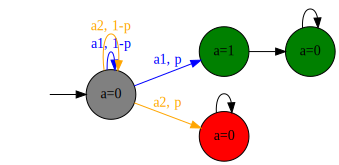

$\mathcal{M}_2$: 

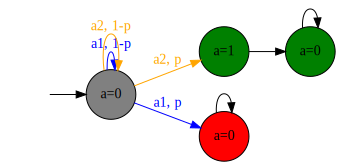


- green: staying in these states creates an **accepting** string for the formula $\mathsf{F} a$
- red: staying in these states creates an **rejecting** string for the formula $\mathsf{F} a$


In [7]:
# visualize_constructed_MDP("a & X a")     # formula is in Finitary
visualize_constructed_MDP("F a")         # formula is in Guarantee
# visualize_constructed_MDP("G a")         # formula is in Safety
# visualize_constructed_MDP("G a & F b")   # formula is in Obligation
# visualize_constructed_MDP("FG a")        # formula is in Persistence
# visualize_constructed_MDP("GF a")        # formula is in Recurrence
# visualize_constructed_MDP("GF a & FG b") # formula is in Reactivity

# visualize_constructed_MDP("!a & X G ((a -> X !a) & (!a -> X a))") # a larger example

To support the fact that the above constructed MDPs are indeed counterexamples, we convert the constructed MDPs into PRISM format and estimate the LTL-PAC probabilities on these constructed counterexampe MDPs.

In [8]:
def rewrite_ltl_formula_for_prism(ltl_formula: str) -> str:
    """Rewrites ltl_formula with proper quoting so it works for prism."""
    ltl = spot.formula(ltl_formula)
    relabel_map = {}
    for ap in spot.atomic_prop_collect(ltl):
        # we add $ here to make spot satisfied with the double quotes...
        # this means that we assumed there are no $ in the AP names
        relabel_map[ap] = spot.formula(f'"${ap}$"')
        relabel_map = spot.relabeling_map(relabel_map)
        ltl_transformed = spot.relabel_apply(ltl, relabel_map)
        # format formula with parenthesis, then remove $
        return f'{ltl_transformed:p}'.replace("$", "")


def to_prism(formula: str, env_title: Optional[str] = None, m1_or_m2 = "M1"):
    """Writes a PRISM model file for the counterexample for a given LTL formula.
    
    Args:
        formula: an LTL formula.
        env_title: the title to prepend to the PRISM file as a comment.
        m1_or_m2: whether to generate M_1 or M_2 as in Figure 2 of the paper.
    
    Returns:
        a file `name` for the model, written to "models/{name}.prism".
    """
    assert m1_or_m2 in ("M1", "M2")

    if env_title is None:
        env_title = f"Constructed MDP for {formula}"
    
    mdp = construct_mdp(formula)

    env = f"constructed-mdp-#{formula}#"
    with pathlib.Path(f"models/{env}.prism").open("w+") as f:
        print(textwrap.dedent(f"""
        // @title: {env_title}
        
        mdp
        
        const double p = {{P}};
        """)[1:], file=f)
        states = {s: ap for s, ap in enumerate(itertools.chain(mdp.g_prefix, mdp.g_cycle, 
                                                               mdp.h_prefix, mdp.h_cycle, 
                                                               mdp.q_prefix, mdp.q_cycle))
                 }
        
        for i, ap in enumerate(mdp.aps):
            ap_states = "|".join([f"s={s}" for s, sap in states.items() if sap[i]])
            print(f'label "{ap}" = {ap_states};', file=f)
        
        print("", file=f)
        print("module grid", file=f)
        print(f"  s : [0..{len(states)-1}];", file=f)
        print("", file=f)

        def print_det_chain(start, end):
            for s1 in range(start, end-1):
                s2 = s1 + 1
                print(f"  [] s={s1} -> (s'={s2}) ;", file=f)
        
        g_start, g_cycle, g_end = 0, len(mdp.g_prefix), len(mdp.g_prefix + mdp.g_cycle)
        h_start, h_cycle, h_end = g_end, g_end + len(mdp.h_prefix), g_end + len(mdp.h_prefix + mdp.h_cycle)
        q_start, q_cycle, q_end = h_end, h_end + len(mdp.q_prefix), h_end + len(mdp.q_prefix + mdp.q_cycle)

        print_det_chain(g_start, g_end)
        print(f"  [a1] s={g_end-1} -> 1-p: (s'={g_cycle}) + p: (s'={h_start});", file=f)
        print(f"  [a2] s={g_end-1} -> 1-p: (s'={g_cycle}) + p: (s'={q_start});", file=f)

        print_det_chain(h_start, h_end)
        print(f"  [] s={h_end-1} -> (s'={h_cycle});", file=f)

        print_det_chain(q_start, q_end)
        print(f"  [] s={q_end-1} -> (s'={q_cycle});", file=f)
        
        print("endmodule", file=f)
    
    with pathlib.Path(f"models/{env}.ltl").open("w+") as f:
        prism_formula = rewrite_ltl_formula_for_prism(formula)
        print(prism_formula, file=f)
    
    return env

<multi-discount | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

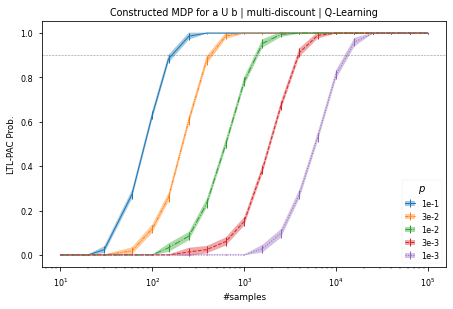

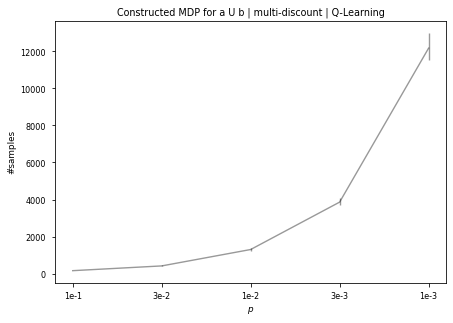

In [16]:
env = to_prism("a U b")
# env = to_prism("FG a") # For more complicated LTL formulas

reward_types = ["zeta-reach", "zeta-acc", "zeta-discount", "multi-discount", "reward-on-acc"]
rl_algos = ["Q", "DQ", "SL"]
# Comment out below to run for only multi-discount and Q-learning
reward_types = ["multi-discount"]
rl_algos = ["Q"]
for rl_algo, reward_type in itertools.product(rl_algos, reward_types):
    probs, errs = collect_pac_probs(
        env,
        # You might need to change these parameters, if the counterexample MDP is large (i.e., more than 4 states).
        # Otherwise, for the given number of samples, the algorithm might not converge to the
        # desired LTL-PAC probability. This will cause the intercept plot (e.g., right of Figure 3) to have
        # infinities, which matplotlib will emit a waring when during plotting.
        ep_numbers = default_ep_numbers,
        ep_length = default_ep_length,
        rl_algo=rl_algo, 
        reward_type=reward_type, 
        skip_after_stable=3
    )
    plot_pac_probs(env, probs, errs, 
                   rl_algo=rl_algo, 
                   ep_numbers = default_ep_numbers,
                   ep_length = default_ep_length, 
                   reward_type=reward_type, 
                   plot_for_paper=False)

# Gridworld environment

<zeta-reach | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

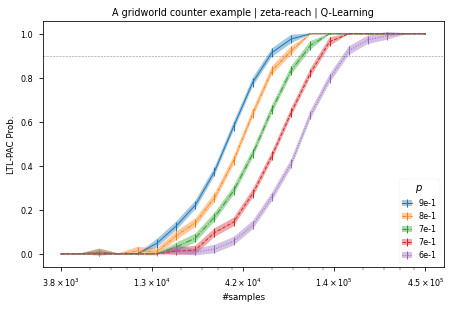

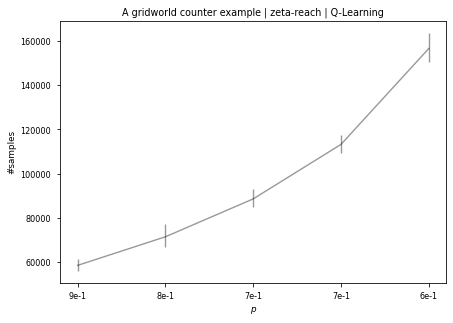

<zeta-acc | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

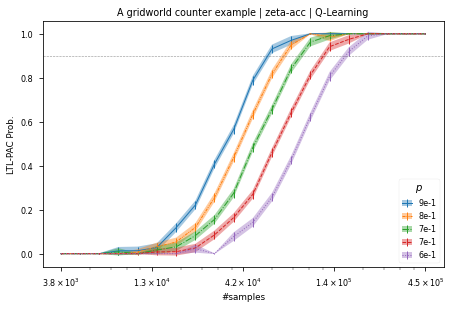

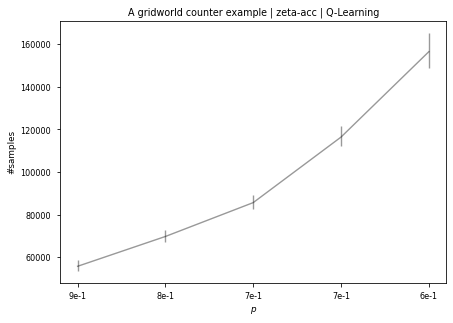

<zeta-discount | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

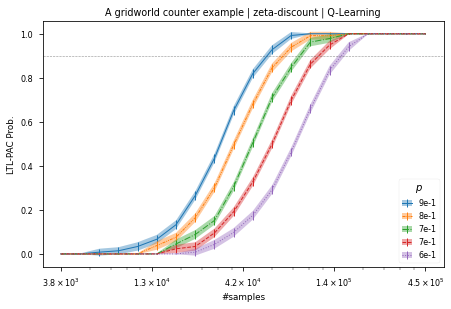

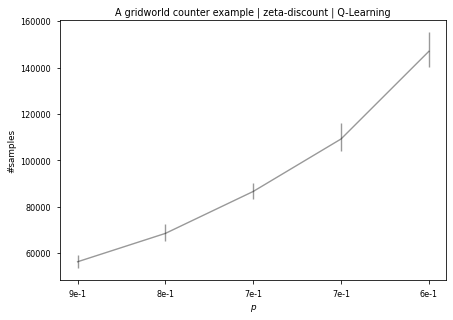

<multi-discount | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

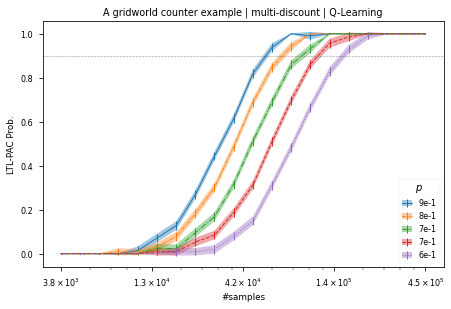

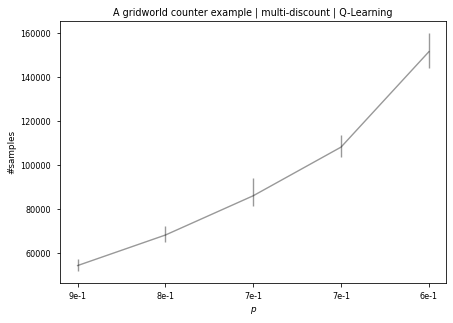

<reward-on-acc | Q > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

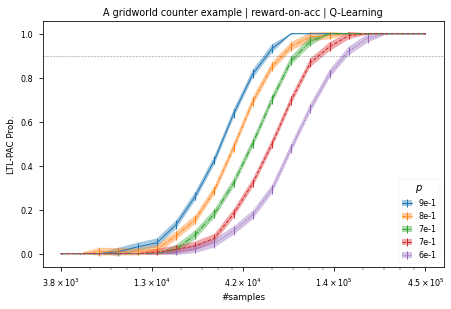

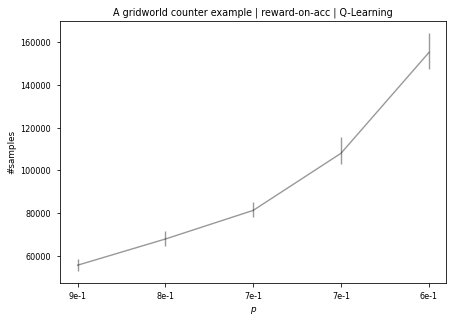

<zeta-reach | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

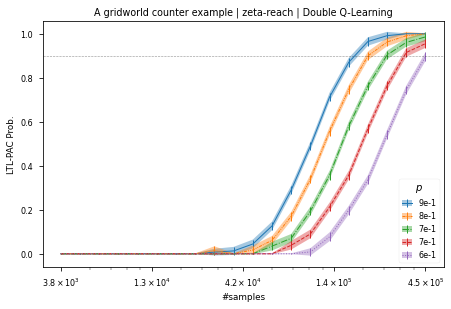

/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/ipykernel_36223/330959130.py:184: RuntimeWarning: invalid value encountered in subtract
  plt.errorbar(range(len(ps)), line, yerr=np.array([line-lower, upper-line]), color="#000", alpha=0.4)


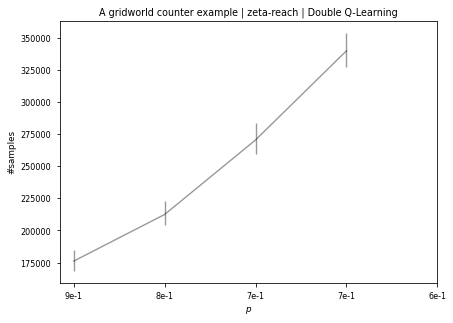

<zeta-acc | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

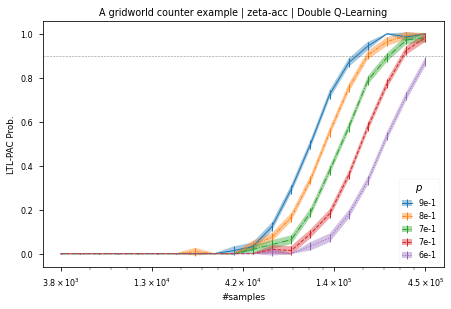

/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/ipykernel_36223/330959130.py:184: RuntimeWarning: invalid value encountered in subtract
  plt.errorbar(range(len(ps)), line, yerr=np.array([line-lower, upper-line]), color="#000", alpha=0.4)


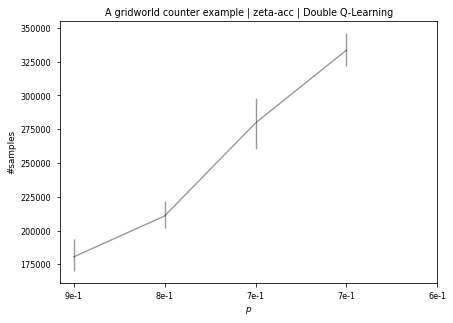

<zeta-discount | DQ > Iteration over p:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration over N:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [131]:
env = "gridworld_sadigh14"

reward_types = ["zeta-reach", "zeta-acc", "zeta-discount", "multi-discount", "reward-on-acc"]
rl_algos = ["Q", "DQ", "SL"]
# # Comment out below to run for only multi-discount and Q-learning
# reward_types = ["multi-discount"]
# rl_algos = ["Q"]

ps = np.geomspace(0.9, 0.6, num=5)
ep_numbers = np.geomspace(200, 20000, num=21, dtype=int)[1:]
ep_length = 30

for rl_algo, reward_type in itertools.product(rl_algos, reward_types):
    probs, errs = collect_pac_probs(
        env,
        ps=ps,
        ep_numbers = ep_numbers,
        ep_length = ep_length,
        rl_algo=rl_algo, 
        reward_type=reward_type, 
        skip_after_stable=3
    )
    plot_pac_probs(env, probs, errs, 
                   rl_algo=rl_algo, 
                   reward_type=reward_type, 
                   ep_numbers = ep_numbers,
                   ep_length = ep_length, 
                   plot_for_paper=False)

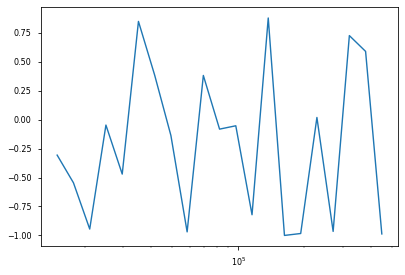

In [49]:
x = np.geomspace(500, 15000, num=21, dtype=int) * 30
plt.plot(x, np.sin(x))
plt.gca().set_xscale("log")
plt.show()


In [50]:
x

array([ 14970,  17760,  21060,  24960,  29610,  35100,  41610,  49320,
        58470,  69300,  82140,  97380, 115440, 136830, 162180, 192270,
       227910, 270150, 320250, 379620, 450000])